Preprocessing and data extraction to npy files for model training

In [ ]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import os
import tensorflow as tf



Gives the bbox and label for n-th box

In [33]:
def read_string(ref, file_ref):
    return "".join([chr(c[0]) for c in file_ref[ref]])

def get_name(i, file_ref):
    names_refs = file_ref["digitStruct"]["name"]
    name_ref = names_refs[i-1][0]
    return read_string(name_ref, file_ref)

def get_boxes(img_num, file_ref, source_dir):
    bbox_refs = file_ref["digitStruct"]["bbox"]
    master_ref = bbox_refs[img_num-1][0]
    bbox_data_struct = file_ref[master_ref]
    label_refs = bbox_data_struct["label"]
    num_of_digits = label_refs.shape[0]

    def get_field(field, digit_num):
        field_refs = bbox_data_struct[field]

        # if only 1 digit in img then refrence is to float
        if (field_refs.dtype == np.dtype("float64")):
            field_value = field_refs[0][0].astype("int16")
        else: # otherwise have to get the that the specific digit_num
            field_value = file_ref[field_refs[digit_num][0]][0][0].astype("int16")

        return field_value

    bboxes_data = []
    label_data = []
    filepath = source_dir + get_name(img_num, file_ref)
    width, height = Image.open(filepath).size

    for i in range(num_of_digits):
        if height > width:
            x = (get_field("left", i) + (height - width) / 2)/ height
            y = get_field("top", i) / height
            box_height = get_field("height", i) / height
            box_width = get_field("width", i) / height
        else:
            x = get_field("left", i) / width
            y = (get_field("top", i) + (width - height) / 2) / width
            box_height = get_field("height", i) / width
            box_width = get_field("width", i) / width
        bbox_data = np.array([x, y, box_height, box_width], dtype='float64')
        bboxes_data.append(bbox_data)
        label_data.append(get_field("label", i))

    bbox_data = np.array([0,0,0,0], dtype='float64')
    while len(bboxes_data) < 6:
        bboxes_data.append(bbox_data)
        label_data.append(0)
    return bboxes_data, label_data

bbox_num = 1
file_ref_train = h5py.File("data/train_digitStruct.mat", "r")
filename = get_name(bbox_num, file_ref_train)
source_dir = "data/train/"
box_info, label_info = get_boxes(bbox_num, file_ref_train, source_dir)
print(filename, box_info, label_info)
width2, height2 = Image.open('data/train/1.png').size
print(width2, height2)


# max_digits # was 6 for training dataset -> set this as the max for model


1.png [array([0.33198381, 0.36774629, 0.29554656, 0.10931174]), array([0.43589744, 0.3731444 , 0.29554656, 0.12955466]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])] [np.int16(1), np.int16(9), 0, 0, 0, 0]
741 350


Saves image data

In [31]:

def save_img_data(source_dir, save_path, n):
    images_array = []
    for i in range(1,n):
        name = str(i) + ".png"
        path = source_dir + name
        image = Image.open(path)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize_with_pad(image, 128, 128)
        image_array = np.array(image) / 255 #shape(height,width,3) - 3 is RGB.
        images_array.append(image_array)
    X_data = np.array(images_array)
    np.save(save_path, X_data)


Saves label data

In [30]:

#Array of bounding boxes for each image
#TODO maybe each array element should have a value for image name.
def save_labels(save_path_bboxes, save_path_labels, n, file_ref, source_dir):
    bbox_array = []
    labels_array = []
    for i in range(1, n):
        bboxes, labels = get_boxes(i, file_ref, source_dir)
        bbox_array.append(bboxes)
        labels_array.append(labels)
    y_data = np.array(bbox_array)
    np.save(save_path_bboxes, y_data)
    labels_data = np.array(labels_array)
    np.save(save_path_labels, labels_data)



Saves training data

In [ ]:
save_img_data("data/train/", "data/X_train.npy", 33403)
save_labels("data/y_train.npy","data/labels_train.npy", 33403, file_ref_train, "data/train/")

Saves test data

In [34]:

file_ref_test = h5py.File("data/test_digitStruct.mat", "r")
save_labels("data/y_test.npy","data/labels_test.npy", 13068, file_ref_test, "data/test/")
save_img_data("data/test/", "data/X_test.npy", 13068)


This displays images and the bounding boxes of the digits (1-500 checked), need to put bad images in bad_data

Attempting to display 50 images from data/train/ with normalized bboxes...


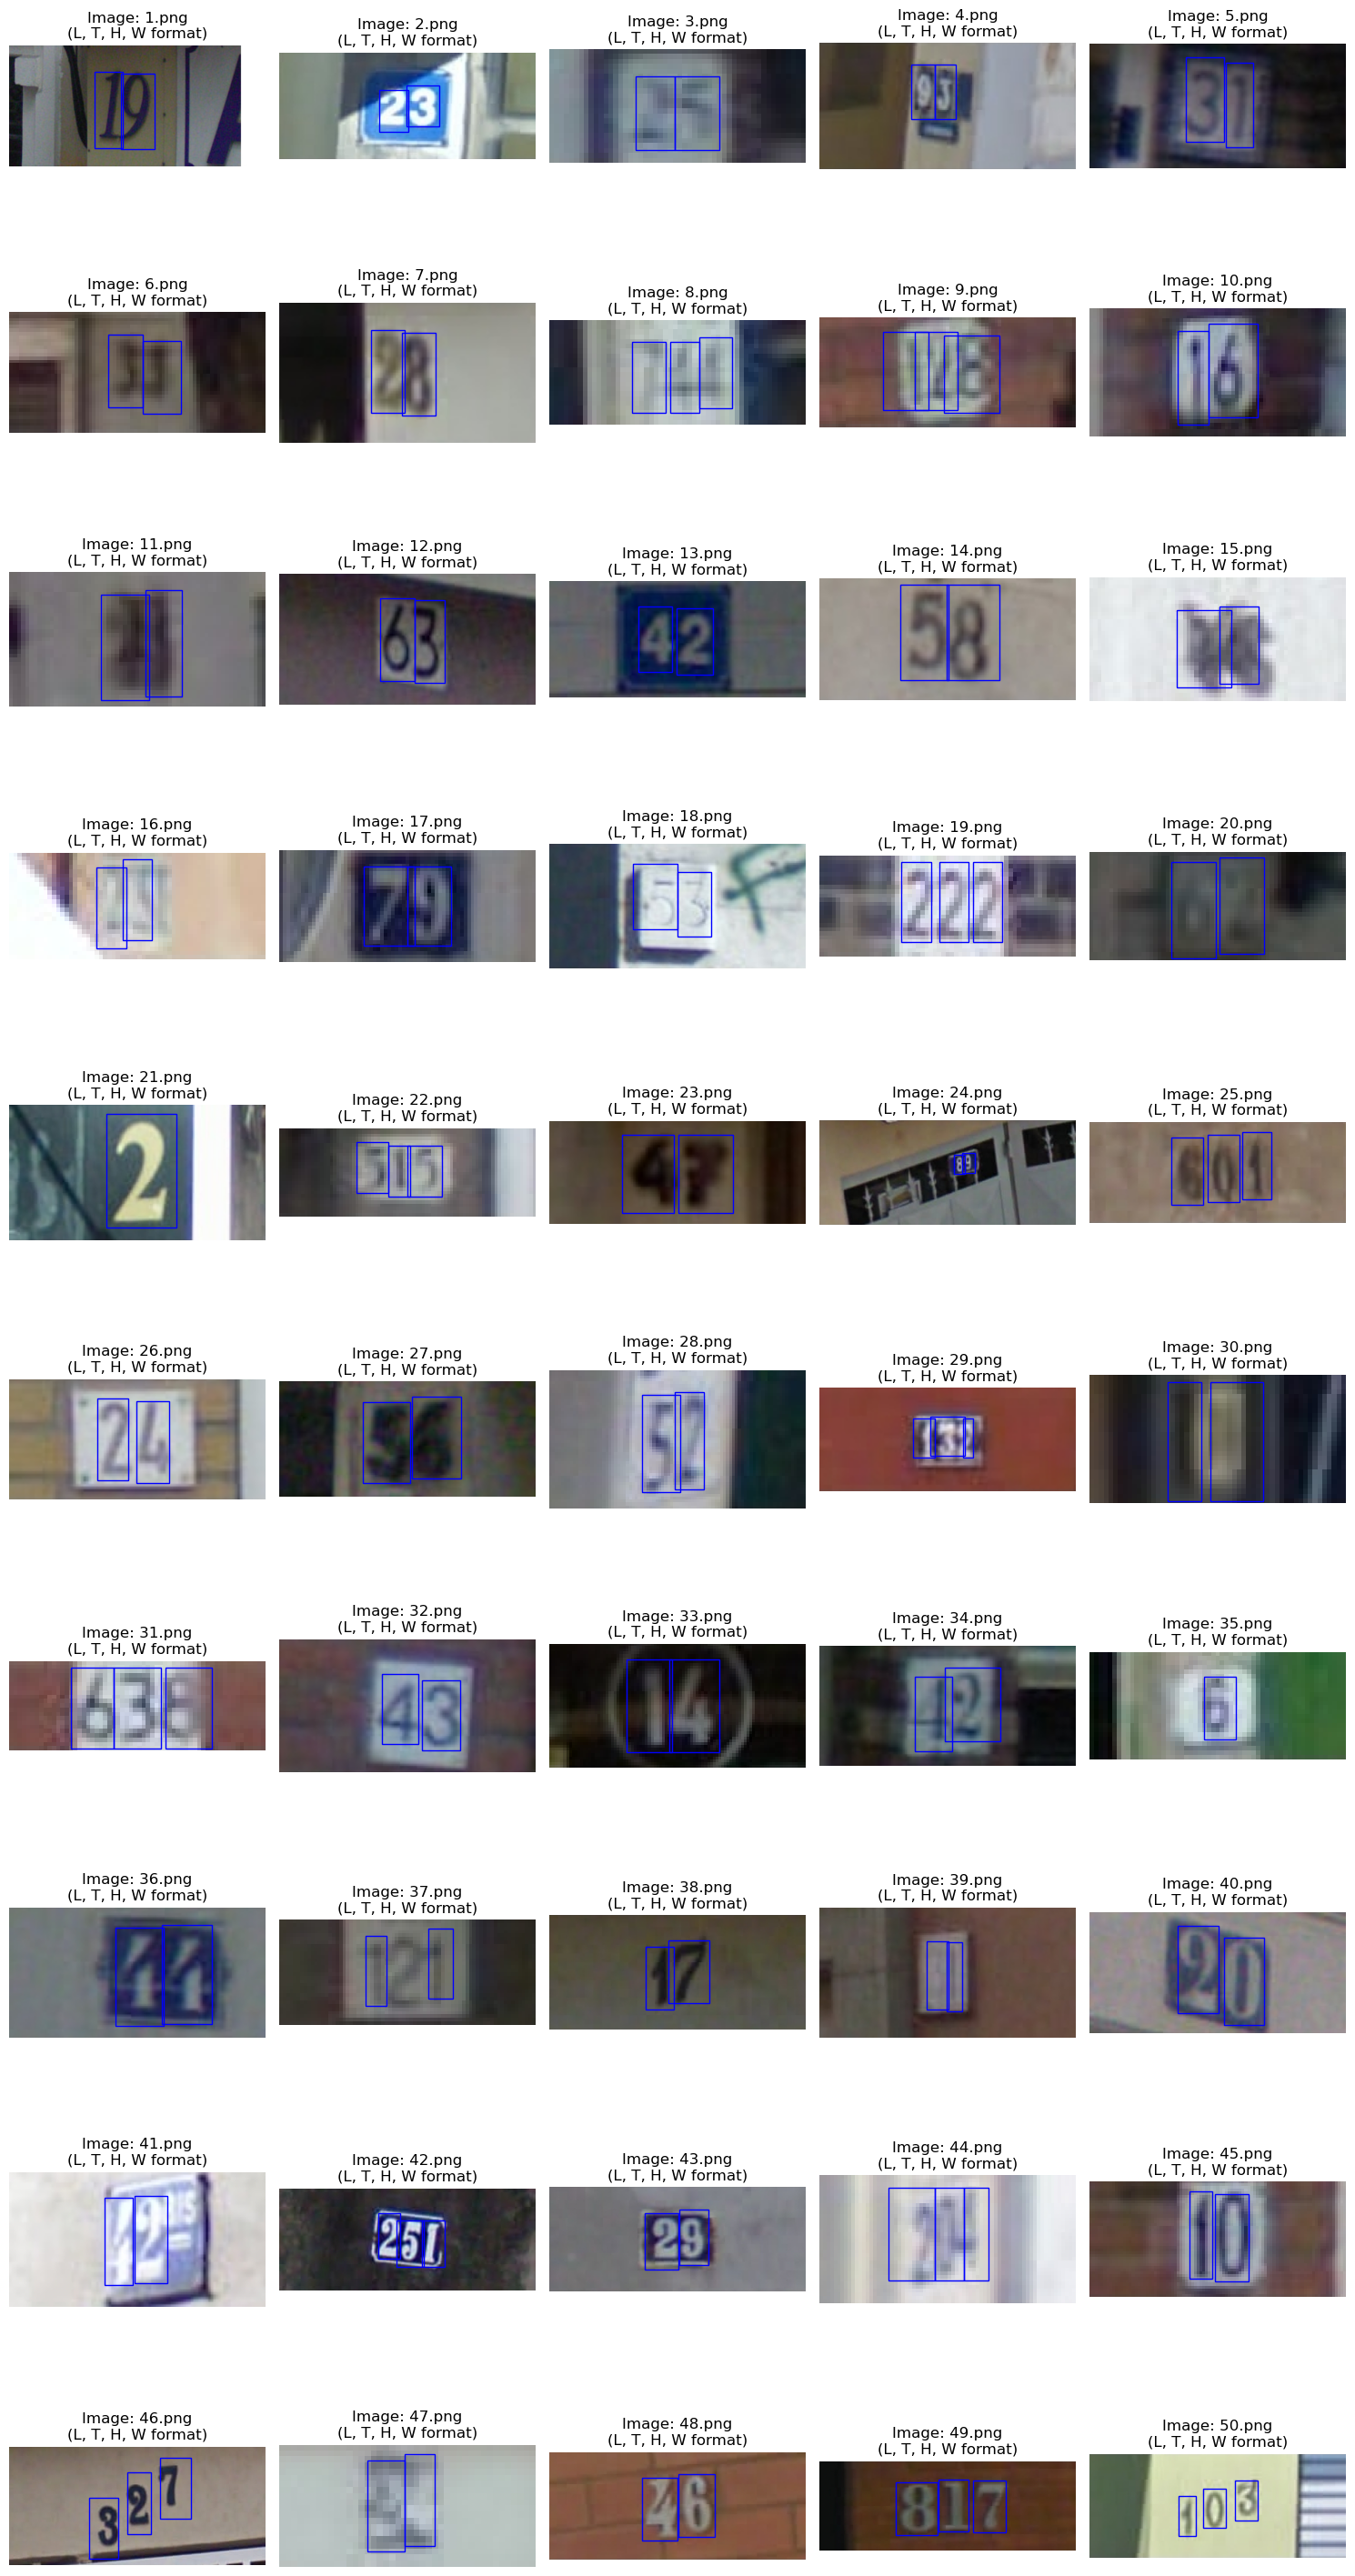

In [35]:
plt.close("all")

def visualize_fixed_bboxes(image_dir, y_train, num_show, rows, cols):
    """
    Loads images and displays them with matplotlib bounding boxes, handling
    NORMALIZED [Left, Top, Height, Width] format by swapping H and W for plotting.
    """
    image_files = sorted(
        [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))],
        key=lambda x: int(os.path.splitext(x)[0]) if os.path.splitext(x)[0].isdigit() else x
    )

    if not image_files:
        print(f"Error: No images found in {image_dir}")
        return

    num_show = min(num_show, len(image_files), len(y_train))
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten()

    for i in range(num_show):
        try:
            # 1. Load the Image and get dimensions
            img_path = os.path.join(image_dir, image_files[i])
            image = Image.open(img_path)
            image_array = np.array(image)

            ax = axes[i]

            ax.imshow(image_array)

            boxes_for_image = y_train[i]

            width, height = image.size
            max_length = max(width, height)

            # --- Calculate Padding Offsets ---
            # These offsets are needed to convert from the 'squared' normalized space
            # back into the original image's coordinate system.
            pad_x = 0
            pad_y = 0

            if height > width:
                # Image was padded horizontally (left/right)
                pad_x = (height - width) / 2
            elif width > height:
                # Image was padded vertically (top/bottom)
                pad_y = (width - height) / 2

            # The normalization factor is the max dimension
            # max_length is already correctly calculated as max(width, height)

            for bbox in boxes_for_image:
                # The format in y_train is: [L, T, H, W]
                normalized_left, normalized_top, normalized_height, normalized_width = bbox

                if np.sum(bbox) == 0:
                    continue

                # --- RESCALE COORDINATES AND REMOVE PADDING OFFSET ---

                # 1. Rescale by multiplying by the normalization factor (max_length)
                left_rescaled = normalized_left * max_length
                top_rescaled = normalized_top * max_length

                # 2. Subtract the padding offset to get coordinates in the original image space
                left_pixel = left_rescaled - pad_x
                top_pixel = top_rescaled - pad_y

                # 3. Rescale Dimensions (dimensions do not have padding offset applied)
                pixel_width = normalized_width * max_length
                pixel_height = normalized_height * max_length

                # 4. Create the Matplotlib Bounding Box Patch (W, H are already correct from y_train)
                # Matplotlib requires (Left, Top, Width, Height)
                rect = patches.Rectangle(
                    (left_pixel, top_pixel), # Top-Left corner (NOW CORRECTED)
                    pixel_width,             # Width
                    pixel_height,            # Height                    linewidth=2,
                    edgecolor='blue',
                    facecolor='none'
                )

                ax.add_patch(rect)

            ax.set_title(f"Image: {image_files[i]}\n(L, T, H, W format)")
            ax.axis('off')

        except Exception as e:
            print(f"Could not process image {image_files[i]}: {e}")

    # Hide any unused subplots if num_show is less than ROWS * COLS
    for j in range(num_show, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

NUM_IMAGES_TO_SHOW = 50
IMAGE_DIR = 'data/train/'
COLS = 5
ROWS = int(np.ceil(NUM_IMAGES_TO_SHOW / COLS))
y_train = np.load("data/y_train.npy", allow_pickle=True)
print(f"Attempting to display {NUM_IMAGES_TO_SHOW} images from {IMAGE_DIR} with normalized bboxes...")
visualize_fixed_bboxes(IMAGE_DIR, y_train, NUM_IMAGES_TO_SHOW, ROWS, COLS)

Below doesnt work yet

In [36]:

import keras
model_path = 'models/svhnModel.keras'

loaded_model = keras.models.load_model(model_path)

# loaded_model.summary()

data_X_test = np.load("data/X_test.npy", allow_pickle=True)
data_y_test = np.load("data/y_test.npy", allow_pickle=True)
data_labels_test = np.load("data/labels_test.npy", allow_pickle=True)
print(data_X_test.shape)
print(data_y_test.shape)
print(data_labels_test.shape)
ds_test = tf.data.Dataset.from_tensor_slices((data_X_test, {"bboxes": data_y_test, "classes": data_labels_test}))
ds_test = ds_test.batch(64).prefetch(tf.data.AUTOTUNE)


✅ Model loaded successfully!
(13067, 128, 128, 1)
(13067, 6, 4)
(13067, 6)


In [38]:
results = loaded_model.evaluate(ds_test)
print(results)
print('Test loss: %.4f accuracy: %.4f' % (results[2], results[4]))
# data_X_test = None
# data_y_test = None
# data_labels_test = None
# ds_test = None


205/205 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - bboxes_loss: 0.0025 - bboxes_mse: 0.0051 - classes_accuracy: 0.8562 - classes_loss: 0.8038 - loss: 0.8338
[0.8337697386741638, 0.0025495593436062336, 0.803767204284668, 0.00510273315012455, 0.8562409281730652]
Test loss: 0.8038 accuracy: 0.8562
